# **Wines Classifier**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# load the data into wines variable
wines = pd.read_csv('wine.csv')
wines.head()

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


**Note**<br>
    The scales of the different attributes differ, some are in the hundreds, and others vary between 0 and 1.

<h3>Separate the label from the data</h3>

In [3]:
Y = np.array(wines['Customer_Segment']).reshape((178,1)) #label
X = np.array(wines.drop('Customer_Segment', axis=1)) #data

In [4]:
print(f'X: {X.shape[0]} rows; {X.shape[1]} columns\nY: {Y.shape[0]} rows; {Y.shape[1]} column')

X: 178 rows; 13 columns
Y: 178 rows; 1 column


<h3>Let´s write a function to normalize the data</h3>

First, create a function to compute the standard deviation.

Let the vector be: $[X_1,X_2,...,X_n]$<br>
To calculate the result I use the following equations:<br><br>
$mean = (\sum_{i=1}^{n} X_i)/n$<br><br>
$s = \sqrt{\frac{1}{n-1} \sum_{i=1}^{n} (X_i - mean)^{2}}$

In [5]:
def desviacion_standard(vector):

    mean = sum(vector) / len(vector)

    sumatoria = 0
    for i in range(len(vector)):
        sumatoria += (vector[i] - mean)**2

    s = np.sqrt(sumatoria / (len(vector) - 1))
    return (s, mean)

In [6]:
def normalize(matrix):
    '''
    Given a numpy array, returns the normalized numpy array.
    '''
    rows, cols = matrix.shape
    
    for i in range(cols):
        current_col = matrix[:,i]
        
        s, mean = desviacion_standard(current_col)

        for f in range(rows):
            matrix[f,i] = (matrix[f,i] - mean) / s


    return matrix

In [7]:
norm_X = normalize(X)

Now I have the matrix with the normalized values, this is important as a prior step to looking for covariances between the attributes of the wines. <br><br>
As we had seen in the dataframe, there are columns with scales larger than others, which was going to be a complication when deciding whether a relationship between two attributes is strong or weak. <br><br>
With this step we ensure that all the variables have a mean of zero. Since the PCA process identifies those directions in which the variance is greater, all variables must be scaled to be comparable, otherwise those variables whose scale is greater will dominate the rest.

<h3>We obtain the covariance matrix</h3>

In statistics, the covariance matrix is ​​used to analyze the relationship between two or more random variables. It is very useful because it allows you to interpret the correlation between many variables quickly, since it allows you to see the values ​​of all the covariances of the variables at the same time.

The values ​​along the diagonals of the matrix are simply the variations of each variable.
A positive covariance number indicates that two variables tend to increase or decrease together.
A negative covariance number indicates that as one variable increases, a second variable tends to decrease.

To better understand what this is about, let's assume that we only have<br>
three attributes of wines: $x$, $y$ and $z$. The covariance matrix will have the form:<br><br>
$
\begin{pmatrix}
var_{x} & con_{xy} & cov_{xz}\\
cov_{xy} & var_{y} & cov_{yz}\\
cov_{xz} & con_{zy} & var_{z}
\end{pmatrix}
$

Where<br>
$cov_{xy}=\frac{\sum_{i=1}^{n} (x_i - media_x)(y_i - media_y)}{n}$
<br>
y
<br>
$cov_{xx}=\frac{\sum_{i=1}^{n} (x_i - media_x)(x_i - media_x)}{n}=var_x$

Note that having the matrix centered at the origin and normalized in the form:<br><br>
$norm\_X=
\begin{pmatrix}
x_1 - media_x & y_1 - media_y & z_1 - media_z\\
x_2 - media_x & y_2 - media_y & z_2 - media_z\\
: & : & :\\
x_{178} - media_x & y_{178} - media_y & z_{178} - media_z\\
\end{pmatrix}
$

We can obtain the covariance matrix by simply calculating the dot product between $the$ $transpose$ $of$ $norm\_X$ and $norm\_X$ and then dividing everything by $n$ (178 in this case)

$cov=
\frac{
\begin{pmatrix}
x_1 - media_x & x_2 - media_x  & ... & x_{178} - media_x\\
y_1 - media_y & y_2 - media_y & ... & y_{178} - media_y\\
z_1 - media_z & z_2 - media_z & ... & z_{178} - media_z
\end{pmatrix}
\begin{pmatrix}
x_1 - media_x & y_1 - media_y & z_1 - media_z\\
x_2 - media_x & y_2 - media_y & z_2 - media_z\\
: & : & :\\
x_{178} - media_x & y_{178} - media_y & z_{178} - media_z\\
\end{pmatrix}
}{n}
$

In [8]:
def covariance(matriz):
    
    # obtenemos n (numero de filas, osea de vinos)
    n = matriz.shape[0]

    # multiplicamos la transpuesta y la matriz y dividimos por n
    C = np.dot(np.transpose(matriz),matriz) / n

    return C

In [9]:
# guardo la matriz de covarianza en una variable
cov_X = covariance(norm_X)

<h3>We apply the power method</h3>
And find the maximum eigenvector with its eigenvalue

In [10]:
def max_eigenvec_eigenval(A):
    
    v = np.random.rand(A.shape[0])
    former_v = np.random.rand(A.shape[0])

    for i in range(1000): 
        Av = A @ v
        v = Av / np.linalg.norm(Av, 2)
        
        if np.allclose(v,former_v):
            break

        former_v = v.copy()

    v_shape = (len(v), 1)
    eigenvector = v.reshape(v_shape)

    eigenvalue = np.linalg.norm(A @ v, 2)

    return(eigenvector, eigenvalue)

<h3>But we want the n maximum eigenvectors</h3>

In [11]:
def n_eigenvec_eigenval(A, n):

    matriz = A.copy()
    
    results = []
    
    for i in range(n):
        eigenvector, eigenval = max_eigenvec_eigenval(matriz)
        results.append((eigenval, eigenvector))

        # we eliminate the component corresponding to the eigenvalue found
        matriz -= eigenval * np.dot(eigenvector, np.transpose(eigenvector))

    return results

At this point, we will obtain the classification of a particular wine based on a given set of characteristics, that is, to which customer segment it belongs.

To do this, we first define the following function:

$matrix\_W$ creates the $W$ matrix with the main components.
<br>
Where $T = X.W$ gives me projection of the points on the principal components.

In [12]:
def matrix_W(pc):
    
    eigenvectors = []
    
    for i in range(len(pc)):
        eigenvectors.append(pc[i][1])

    dim_vector = len(eigenvectors[0])
    
    W = np.array(eigenvectors).reshape((dim_vector), len(pc))
    
    return W

Then, we create the function *projection*, which, given a data with the wine(s) to be classified and the main eigenvector(s), returns the matrix T, whose rows are the projected points.

T explains the dependent variable Y from a linear combination of the original data where only the first n terms are considered for each observation.

In [13]:
def projection(data, componentes_principales):
    
    # T = X.W
    T = data @ matrix_W(componentes_principales)
    
    return T

**Now, We implement the kNN algorithm**

In [14]:
def predict(new_wine, T_train, Y_train, k):
    
    distances = []
    for i in range(T_train.shape[0]):
        euclidea = np.sqrt(sum((new_wine - T_train[i,:])**2))
        distances.append(euclidea)

    sorted_indexes = np.argsort(distances)[:k]

    k_neighbors = Y_train[sorted_indexes].reshape((k,))

    prediction = np.bincount(k_neighbors).argmax()
    
    return prediction

In [15]:
def knn(T_test, T_train, Y_train, k):
    
    y_pred = []
    for i in range(T_test.shape[0]):
        pred = predict(T_test[i,:], T_train, Y_train, k)
        y_pred.append(pred)

    return y_pred

**Now we evaluate our model, dividing the data into train and test sets.**

In [16]:
def split_data(data, label):
    
    filas = data.shape[0]
    np.random.seed(42)
    random_indexes = np.random.randint(0,filas - 1, filas)

    # 20% test // 80% train
    limit = filas // 5

    train_data = data[random_indexes[limit:],:]
    train_lab = label[random_indexes[limit:],:]
    test_data = data[random_indexes[:limit],:]
    test_lab = label[random_indexes[:limit],:]
    
    return train_data, train_lab, test_data, test_lab

In [17]:
X_train, Y_train, X_test, Y_test = split_data(norm_X, Y)

<h3>Creating the models</h3>
Using 1, 2, 3 y 4 eigenvectors, having 4 distinct models.

In [18]:
modelo1 = n_eigenvec_eigenval(cov_X, 1)
modelo2 = n_eigenvec_eigenval(cov_X, 2)
modelo3 = n_eigenvec_eigenval(cov_X, 3)
modelo4 = n_eigenvec_eigenval(cov_X, 4)

In [19]:
info_table = n_eigenvec_eigenval(cov_X, 13)

eigenvalues = [tupla[0] for tupla in info_table]

In [20]:
def explained_variation(eigenvalues_, n):
    
    sum_ev = sum(eigenvalues)
    expl_vars = []
    
    # calculamos la varianza explicada de los primeros n autovalores y las guardamos
    for i in range(n):
        current_expl_var = eigenvalues_[i] / sum_ev
        expl_vars.append(current_expl_var)

    return expl_vars

In [21]:
explained_variations = explained_variation(eigenvalues, 4)

for i in range(len(explained_variations)):
    print(f"explained variation of the eigenvalues {i + 1}: {explained_variations[i]}")

explained variation of the eigenvalues 1: 0.3619884809990597
explained variation of the eigenvalues 2: 0.19207490256998128
explained variation of the eigenvalues 3: 0.11123630536226191
explained variation of the eigenvalues 4: 0.07069030182672668


The percentages are obtained simply by multiplying the explained variance by 100.

In [22]:
percentages = [x * 100 for x in explained_variations]

for i in range(len(percentages)):
    print(f"percentaje in variance by the eigenvalue {i + 1}: {percentages[i].round(2)} %")

percentaje in variance by the eigenvalue 1: 36.2 %
percentaje in variance by the eigenvalue 2: 19.21 %
percentaje in variance by the eigenvalue 3: 11.12 %
percentaje in variance by the eigenvalue 4: 7.07 %


Now we obtain the accumulated percentage for each model.

In [23]:
accum = [sum(percentages[:i + 1]) for i in range(len(percentages))]


for i in range(len(accum)):
   print(f"accum by the model with {i + 1} principal/s component/s: {accum[i].round(2)} %")

accum by the model with 1 principal/s component/s: 36.2 %
accum by the model with 2 principal/s component/s: 55.41 %
accum by the model with 3 principal/s component/s: 66.53 %
accum by the model with 4 principal/s component/s: 73.6 %


<table>
    <thead>
        <tr>
            <th>Model PCA</th>
            <th>Component</th>
            <th>Explained variation</th>
            <th>Percentage</th>
            <th>Accumulated</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td align="center">1 Principal Component</td>
            <td align="center">1</td>
            <td align="center">0.36</td>
            <td align="center">36.2 %</td>
            <td align="center">36.2 %</td>
        </tr>
        <tr>
            <td rowspan=2 align="center">2 Principal Components</td>
            <td align="center">1</td>
            <td align="center">0.36</td>
            <td align="center">36.2 %</td>
            <td rowspan= 2 align="center">55.41 %</td>
        </tr>
        <tr>
            <td align="center">2</td>
            <td align="center">0.19</td>
            <td align="center">19.21 %</td>
        </tr>
        <tr>
            <td rowspan=3 align="center">3 Principal Components</td>
            <td align="center">1</td>
            <td align="center">0.36</td>
            <td align="center">36.2 %</td>
            <td rowspan=3 align="center">66.53 %</td>
        </tr>
        <tr>
            <td align="center">2</td>
            <td align="center">0.19</td>
            <td align="center">19.21 %</td>
        </tr>
        <tr>
            <td align="center">3</td>
            <td align="center">0.11</td>
            <td align="center">11.12 %</td>
        </tr>
        <tr>
            <td rowspan=4 align="center">4 Principal Components</td>
            <td align="center">1</td>
            <td align="center">0.36</td>
            <td align="center">36.2 %</td>
            <td rowspan=4 align="center">73.6 %</td>
        </tr>
        <tr>
            <td align="center">2</td>
            <td align="center">0.19</td>
            <td align="center">19.21 %</td>
        </tr>
        <tr>
            <td align="center">3</td>
            <td align="center">0.11</td>
            <td align="center">11.12 %</td>
        </tr>
        <tr>
            <td align="center">4</td>
            <td align="center">0.07</td>
            <td align="center">7.07 %</td>
        </tr>
    </tbody>
</table>

With this information, we know that the principal component explains about 36.2% of the variability in the 13 original variables, so the complexity of the data set can be greatly reduced by using this component.

As more components are used, the complexity decreases, with only 26.4% information loss using all 4.

**Let´s plot some visualizations**

Text(0.5, 1.0, 'Explained variation accumulated by Model')

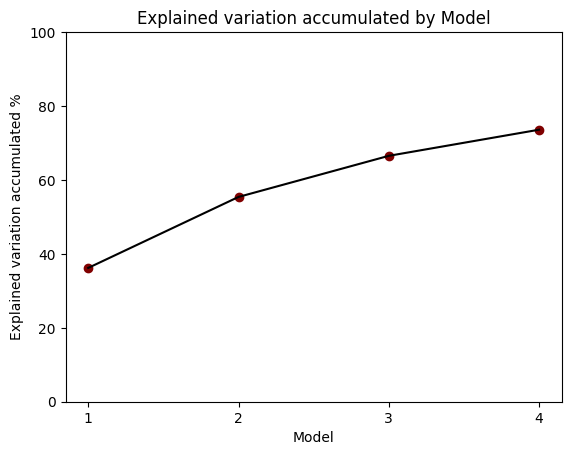

In [24]:
plt.scatter(['1','2','3','4'], accum, color = 'maroon')
plt.plot(['1','2','3','4'], accum, color = 'black')
plt.ylim(0,100)


plt.xlabel('Model')
plt.ylabel('Explained variation accumulated %')
plt.title('Explained variation accumulated by Model')

Text(0.5, 1.0, 'Explained variation by Component')

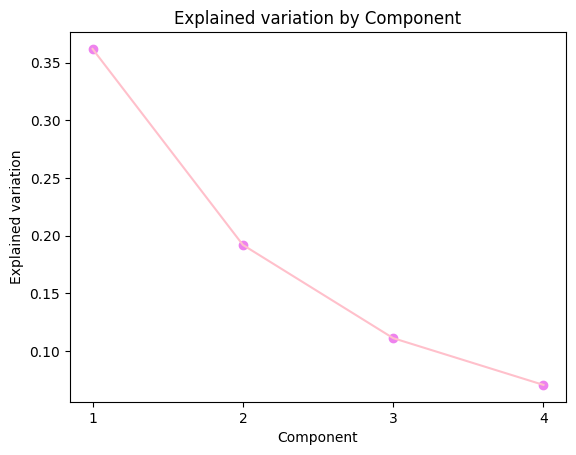

In [25]:
plt.scatter(['1','2','3','4'], explained_variations, color = 'violet')
plt.plot(['1','2','3','4'], explained_variations, color = 'pink')

# añadimos etiquetas y título
plt.xlabel('Component')
plt.ylabel('Explained variation')
plt.title('Explained variation by Component')

<h3>Let´s find out how accurate the Models are.</h3>

In [26]:
def predict_y(modelo):

    T_train = projection(X_train, modelo)
    T_test = projection(X_test, modelo)

    Y_estimated = knn(T_test, T_train, Y_train, 3)

    return Y_estimated

In [27]:
# get each models prediction
EstimatedY_model1 = predict_y(modelo1)
EstimatedY_model2 = predict_y(modelo2)
EstimatedY_model3 = predict_y(modelo3)
EstimatedY_model4 = predict_y(modelo4)

In [28]:
accuracy_model1 = np.mean(EstimatedY_model1 == Y_test.reshape((35,)))
accuracy_model2 = np.mean(EstimatedY_model2 == Y_test.reshape((35,)))
accuracy_model3 = np.mean(EstimatedY_model3 == Y_test.reshape((35,)))
accuracy_model4 = np.mean(EstimatedY_model4 == Y_test.reshape((35,)))

In [29]:
success_percentage = [accuracy_model1, accuracy_model2, accuracy_model3, accuracy_model4]

Text(0.5, 1.0, 'Success Percentage by Model')

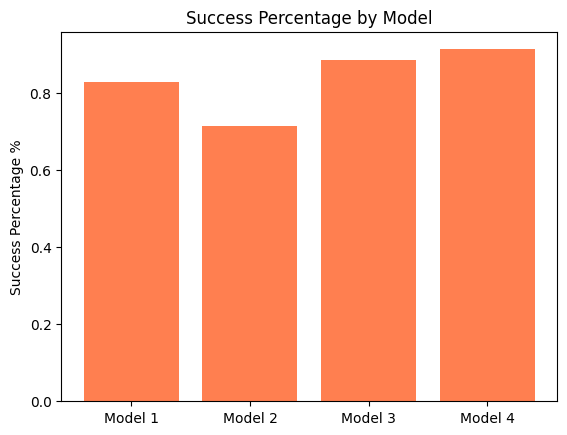

In [30]:
plt.bar(['Model 1','Model 2','Model 3', 'Model 4'], success_percentage, color = 'coral')

# añadimos etiquetas y título
plt.ylabel('Success Percentage %')
plt.title('Success Percentage by Model')

Text(0.5, 1.0, 'Comparison of eigenvalues')

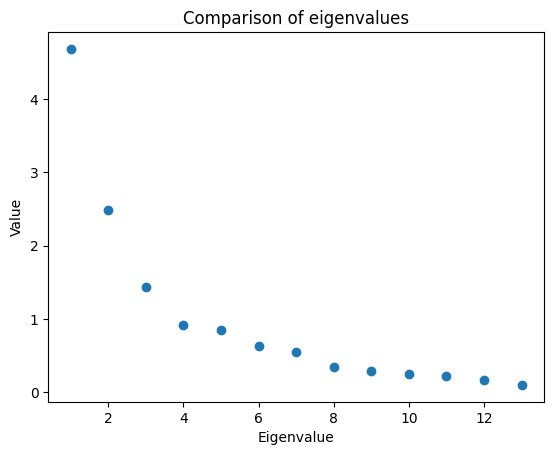

In [31]:
plt.clf()
plt.scatter([i + 1 for i in range(13)],eigenvalues)

# añadimos etiquetas y título
plt.xlabel('Eigenvalue')
plt.ylabel('Value')
plt.title('Comparison of eigenvalues')

With these plots and the table, we suggest using model3 to predict the segment to which it belongs
the wine.

This is because, if we take into account that the aim is to make a recommendation quickly, although model 4 is the one
With a higher percentage of correct answers, model 3 had a similar percentage and uses one less component.

On the other hand, if faster speed is needed, we recommend using model 1, which, although it has a lower percentage of
successes than the other two models, this percentage was quite good and it is the model that uses the fewest components.

If we do not take into account the time factor, model 4 is the most recommended model to predict.

Calculate the confusion matrix for each of the models

In [32]:
def confusion_matrix(prediction, test):
    
    matrix = np.zeros((3,3))
    n = test.shape[0]
     
    for i in range(0,n):
        for k in range(0,4):
            if test[i] == k:
                if prediction[i] == 1:
                    matrix[k-1][0] += 1
                if prediction[i] == 2:
                    matrix[k-1][1] += 1
                if prediction[i] == 3:
                    matrix[k-1][2] += 1
                    
    return matrix

In [33]:
confusion_matrix(EstimatedY_model1, Y_test)

array([[13.,  0.,  0.],
       [ 4., 10.,  1.],
       [ 0.,  1.,  6.]])

In [34]:
confusion_matrix(EstimatedY_model2, Y_test)

array([[12.,  1.,  0.],
       [ 4., 10.,  1.],
       [ 0.,  4.,  3.]])

In [35]:
confusion_matrix(EstimatedY_model3, Y_test)

array([[12.,  0.,  1.],
       [ 2., 12.,  1.],
       [ 0.,  0.,  7.]])

In [36]:
confusion_matrix(EstimatedY_model4, Y_test)

array([[12.,  1.,  0.],
       [ 1., 13.,  1.],
       [ 0.,  0.,  7.]])

If we compare the 4 confusion matrices, we can see that model 4 is the best at predicting:
    
    - In the first confusion matrix, we can see that model 1 presented few errors, having more problems
    to detect classification 2 wines, mostly confusing them with type 1.
    
    - In the second, we can see that for model 2 the number of errors increases for classifications 1 and 3,
    while the errors of type 2 wines remain.
    From this, we can conclude that model1 is better at predicting than model2.
    
    - In the third, we can see that model 3 presented few errors (less than model 1), it had problems to
    detect some wines of classification 1 and 2.
    
    - Finally, in the fourth, we see that model 4 is the one that presented the fewest errors. Although it had errors both
    For classification 1 and 2, these were very few. For this reason we say that this model is the best
    to predict.